# Introduction
The purpose of this script is to do Exploratory analysis of how similar the demand of each country is to one another. Instead of using actual country or product features, I am using the approach of comparing weighted demand of SKU products to represent preference of a country relative to another.<br>
The novel elements of this script is the way I approach missing data via an iterative clustering methodology (see last section).

# Import Packages and Clean Data

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re

import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import os

import random

In [2]:
ros = pd.read_excel("data\Online Retail.xlsx")
ros = ros.applymap(lambda s:s.upper() if type(s) == str else s)
ros = ros.drop(ros.index[0])
ros = ros.reset_index(drop=True)
ros.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
1,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,UNITED KINGDOM
2,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
4,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,UNITED KINGDOM


In [3]:
# Set which value you want to compare by
value_type = 'Quantity'

# Function to format strings to numbers
def parseNumber(value, as_int=False):
    try:
        number = float(re.sub('[^.\-\d]', '', value))
        if as_int:
            return int(number + 0.5)
        else:
            return number
    except ValueError:
        return float('nan')  # or None if you wish

# To format mixed strings and int into integers
temp_list = []
for i in ros[value_type]:
    if type(i) == int:
        temp_list.append(i)
    else:
        temp_list.append(parseNumber(i))
ros[value_type] = temp_list
del(temp_list)

ros.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
1,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,UNITED KINGDOM
2,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,UNITED KINGDOM
4,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,UNITED KINGDOM


# Hierachical Clustering
Since not all sales data exists for every SKU (StockCode), we want to limit the Country comparison to just Top 10 for visualisation purposes.

In [4]:
# Set which category you want to compare by, NA here since no categories given
# category = ['CK SHOES', 'SL SHOES']
# ros_cat = ros[ros['Category'].isin(category)].copy()

category = ['ALL']
ros_cat = ros.copy()
final_table = ros_cat[['StockCode','Country',value_type]].groupby(['StockCode','Country'])[value_type].sum().unstack('StockCode').reset_index()

# Get countries by Total Sold Qty all time
country_summary = ros_cat[['Country',value_type]].groupby(['Country'])[value_type].sum().reset_index()
country_summary = country_summary.sort_values(by=[value_type], ascending=False)

# Top XX countries compare
top_no = 10
final_cty_list = list(country_summary['Country'])[0:(top_no-1)]
final_table_15 = final_table[final_table['Country'].isin(final_cty_list)].copy()
final_table_15 = final_table_15.reset_index(drop=True)
final_table_15 = final_table_15.dropna(axis='columns')

# Weight the columns down
final_columns = [i for i in list(final_table_15) if i not in ['Country']]
final_table_15['Total'] = final_table_15[final_columns].sum(axis='columns')

for col in final_columns:
    final_table_15[col] = final_table_15[col]/final_table_15['Total']
    
final_table_15.head()

StockCode,Country,20712,20713,20725,20726,20728,20973,21210,21212,21213,...,23297,23298,23307,23382,23480,84380,84988,84997D,85099B,Total
0,AUSTRALIA,0.001548,0.000516,0.014447,0.013931,0.002580,0.019813,0.019813,0.018575,0.007430,...,0.013622,0.009907,0.012383,0.001857,0.002477,0.007430,0.001238,0.003715,0.010835,19381.0
1,EIRE,0.004444,0.002963,0.043697,0.009036,0.019479,0.003555,0.005333,0.127981,0.014220,...,0.023700,0.038142,0.031995,0.005925,0.000296,0.033921,0.002666,0.001037,0.010813,13502.0
2,FRANCE,0.012825,0.000214,0.038947,0.021932,0.003976,0.008422,0.006669,0.050276,0.015391,...,0.005472,0.004232,0.013338,0.004446,0.008037,0.003078,0.009790,0.006883,0.018811,23391.0
3,GERMANY,0.028175,0.006301,0.016034,0.027304,0.006352,0.017929,0.016188,0.051329,0.011526,...,0.006045,0.004303,0.033502,0.000615,0.005994,0.006147,0.006403,0.004406,0.026740,19521.0
4,NETHERLANDS,0.034229,0.016202,0.029665,0.029665,0.013691,0.008763,0.008763,0.094197,0.017525,...,0.010976,0.001164,0.014262,0.001643,0.006595,0.009036,0.002191,0.010040,0.045638,43823.0


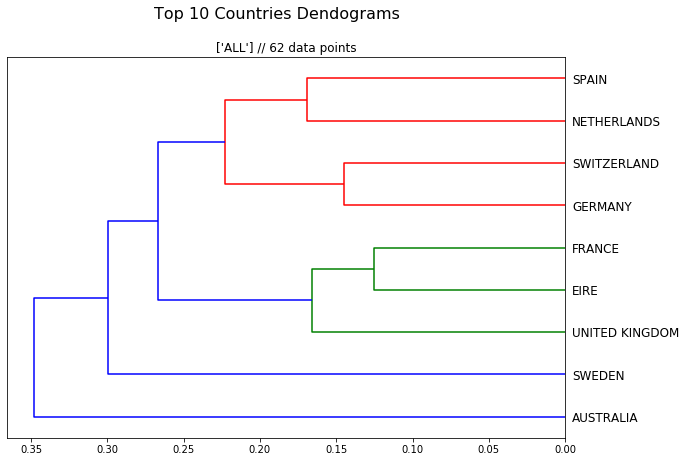

In [5]:
plt.figure(figsize=(10, 7))  

title_string = str(category) + ' // ' + str(len(final_columns)) + ' data points'
plt.title(title_string, fontsize=12)
plt.suptitle('Top '+ str(top_no)+' Countries Dendograms', fontsize=16)
dend = shc.dendrogram(shc.linkage(final_table_15[final_columns], method='ward'), labels=final_cty_list, orientation ='left')
plt.savefig(os.path.join('results',('Top '+ str(top_no) + ' ' + str(category)+'.png')))

This methodology gives us a quick overview that Australia and Sweden are distinct outliers in terms of their demand for goods at this online site. UK, Eire and France forms a cluster; Germany, Switzerland, Netherlands and Spain also form another cluster.<br><br>
However, this method only keeps common StockCodes available since without further information. As shown, there are many StockCodes with missing data when we want to do a cross-comparison of StockCode x Country.

In [6]:
final_table

StockCode,Country,10002,10080,10120,10125,10133,10134,10135,11001,15030,...,DOT,GIFT_0001_10,GIFT_0001_20,GIFT_0001_30,GIFT_0001_40,GIFT_0001_50,M,PADS,POST,S
0,AUSTRALIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,AUSTRIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN
2,BAHRAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BELGIUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272.0,NaN
4,BRAZIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CANADA,NaN,NaN,NaN,NaN,40.0,NaN,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
6,CHANNEL ISLANDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7,CYPRUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN
8,CZECH REPUBLIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
9,DENMARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN


If the StockCodes are in fact equally available to all countries, then the solution is is simple. Instead of dropna on a filtered dataset, I could use the whole dataset directly and fillna(0).

In [7]:
# Set which category you want to compare by, NA here since no categories given
# category = ['CK SHOES', 'SL SHOES']
# ros_cat = ros[ros['Category'].isin(category)].copy()

category = ['ALL']
ros_cat = ros.copy()
final_table = ros_cat[['StockCode','Country',value_type]].groupby(['StockCode','Country'])[value_type].sum().unstack('StockCode').reset_index()

# Get countries by Total Sold Qty all time
country_summary = ros_cat[['Country',value_type]].groupby(['Country'])[value_type].sum().reset_index()
country_summary = country_summary.sort_values(by=[value_type], ascending=False)

# ALL countries compare
final_cty_list = list(country_summary['Country'])
final_table_15 = final_table.copy()
final_table_15 = final_table_15.reset_index(drop=True)
final_table_15 = final_table_15.fillna(0)

# Weight the columns down
final_columns = [i for i in list(final_table_15) if i not in ['Country']]
final_table_15['Total'] = final_table_15[final_columns].sum(axis='columns')

for col in final_columns:
    final_table_15[col] = final_table_15[col]/final_table_15['Total']
    
final_table_15.head()

StockCode,Country,10002,10080,10120,10125,10133,10134,10135,11001,15030,...,GIFT_0001_10,GIFT_0001_20,GIFT_0001_30,GIFT_0001_40,GIFT_0001_50,M,PADS,POST,S,Total
0,AUSTRALIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,83653.0
1,AUSTRIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007665,0.0,4827.0
2,BAHRAIN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,260.0
3,BELGIUM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011748,0.0,23152.0
4,BRAZIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,356.0


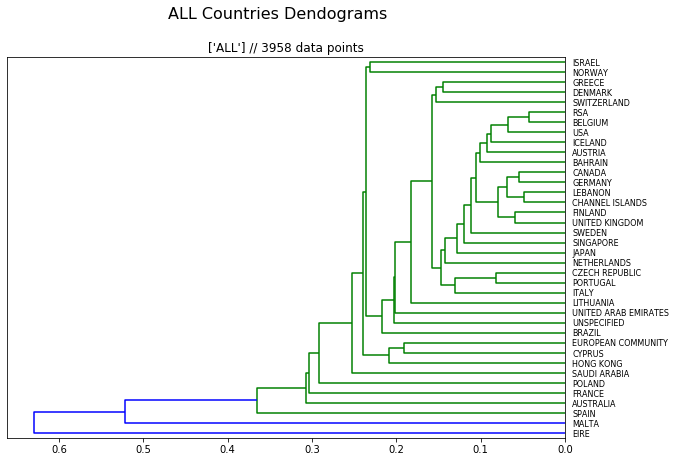

In [8]:
plt.figure(figsize=(10, 7))  

title_string = str(category) + ' // ' + str(len(final_columns)) + ' data points'
plt.title(title_string, fontsize=12)
plt.suptitle('ALL Countries Dendograms', fontsize=16)
dend = shc.dendrogram(shc.linkage(final_table_15[final_columns], method='ward'), labels=final_cty_list, orientation ='left')
plt.savefig(os.path.join('results',('ALL Countries ' + str(category)+'.png')))

# KMeans Clustering
The following runs one loop of the subsequent iterative code for visualisation and understanding purposes. If you wish, you may skip to the next section directly after running the necessary packages here.

In [9]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [10]:
# if min arg error appears, run the following
# default kneed package on my desktop keeps throwing errors even tho I have already updated the package to latest version
# pasting the script here is a work around to my problem

import numpy as np
from scipy import interpolate
from scipy.signal import argrelextrema
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings


class KneeLocator(object):
    def __init__(
        self,
        x,
        y,
        S=1.0,
        curve="concave",
        direction="increasing",
        interp_method="interp1d",
        online=False,
    ):
        """
        Once instantiated, this class attempts to find the point of maximum
        curvature on a line. The knee is accessible via the `.knee` attribute.
        :param x: x values.
        :type x: list or array.
        :param y: y values.
        :type y: list or array.
        :param S: Sensitivity, original paper suggests default of 1.0
        :type S: float
        :param curve: If 'concave', algorithm will detect knees. If 'convex', it
            will detect elbows.
        :type curve: string
        :param direction: one of {"increasing", "decreasing"}
        :type direction: string
        :param interp_method: one of {"interp1d", "polynomial"}
        :type interp_method: string
        :param online: Will correct old knee points if True, will return first knee if False
        :type online: bool
        """
        # Step 0: Raw Input
        self.x = np.array(x)
        self.y = np.array(y)
        self.curve = curve
        self.direction = direction
        self.N = len(self.x)
        self.S = S
        self.all_knees = set()
        self.all_norm_knees = set()
        self.online = online

        # Step 1: fit a smooth line
        if interp_method == "interp1d":
            uspline = interpolate.interp1d(self.x, self.y)
            self.Ds_y = uspline(self.x)
        elif interp_method == "polynomial":
            pn_model = PolynomialFeatures(7)
            xpn = pn_model.fit_transform(self.x.reshape(-1, 1))
            regr_model = LinearRegression()
            regr_model.fit(xpn, self.y)
            self.Ds_y = regr_model.predict(
                pn_model.fit_transform(self.x.reshape(-1, 1))
            )
        else:
            warnings.warn(
                "{} is an invalid interp_method parameter, use either 'interp1d' or 'polynomial'".format(
                    interp_method
                )
            )
            return

        # Step 2: normalize values
        self.x_normalized = self.__normalize(self.x)
        self.y_normalized = self.__normalize(self.Ds_y)

        # Step 3: Calculate the Difference curve
        self.x_normalized, self.y_normalized = self.transform_xy(
            self.x_normalized, self.y_normalized, self.direction, self.curve
        )
        # normalized difference curve
        self.y_difference = self.y_normalized - self.x_normalized
        self.x_difference = self.x_normalized.copy()

        # Step 4: Identify local maxima/minima
        # local maxima
        self.maxima_indices = argrelextrema(self.y_difference, np.greater)[0]
        self.x_difference_maxima = self.x_difference[self.maxima_indices]
        self.y_difference_maxima = self.y_difference[self.maxima_indices]

        # local minima
        self.minima_indices = argrelextrema(self.y_difference, np.less)[0]
        self.x_difference_minima = self.x_difference[self.minima_indices]
        self.y_difference_minima = self.y_difference[self.minima_indices]

        # Step 5: Calculate thresholds
        self.Tmx = self.y_difference_maxima - (
            self.S * np.abs(np.diff(self.x_normalized).mean())
        )

        # Step 6: find knee
        self.knee, self.norm_knee = self.find_knee()

    @staticmethod
    def __normalize(a):
        """normalize an array
        :param a: The array to normalize
        :type a: array
        """
        return (a - min(a)) / (max(a) - min(a))

    @staticmethod
    def transform_xy(x, y, direction, curve):
        """transform x and y to concave, increasing based on given direction and curve"""
        # convert elbows to knees
        if curve == "convex":
            x = x.max() - x
            y = y.max() - y
        # flip decreasing functions to increasing
        if direction == "decreasing":
            y = np.flip(y, axis=0)

        if curve == "convex":
            x = np.flip(x, axis=0)
            y = np.flip(y, axis=0)

        return x, y

    def find_knee(self,):
        """This function finds and sets the knee value and the normalized knee value. """
        if not self.maxima_indices.size:
            warnings.warn(
                "No local maxima found in the difference curve\n"
                "The line is probably not polynomial, try plotting\n"
                "the difference curve with plt.plot(knee.x_difference, knee.y_difference)\n"
                "Also check that you aren't mistakenly setting the curve argument",
                RuntimeWarning,
            )
            return None, None

        # placeholder for which threshold region i is located in.
        maxima_threshold_index = 0
        minima_threshold_index = 0
        # traverse the difference curve
        for i, x in enumerate(self.x_difference):
            # skip points on the curve before the the first local maxima
            if i < self.maxima_indices[0]:
                continue

            j = i + 1

            # reached the end of the curve
            if x == 1.0:
                break

            # if we're at a local max, increment the maxima threshold index and continue
            if (self.maxima_indices == i).any():
                threshold = self.Tmx[maxima_threshold_index]
                threshold_index = i
                maxima_threshold_index += 1
            # values in difference curve are at or after a local minimum
            if (self.minima_indices == i).any():
                threshold = 0.0
                minima_threshold_index += 1

            if self.y_difference[j] < threshold:
                if self.curve == "convex":
                    if self.direction == "decreasing":
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]
                    else:
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[-(threshold_index + 1)]

                elif self.curve == "concave":
                    if self.direction == "decreasing":
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[-(threshold_index + 1)]
                    else:
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]

                self.all_knees.add(knee)
                self.all_norm_knees.add(norm_knee)

                # if detecting in offline mode, return the first knee found
                if self.online is False:
                    return knee, norm_knee

        if self.all_knees == set():
            warnings.warn("No knee/elbow found")
            return None, None

        return knee, norm_knee

    def plot_knee_normalized(self,):
        """Plot the normalized curve, the difference curve (x_difference, y_normalized) and the knee, if it exists."""
        import matplotlib.pyplot as plt

        plt.figure(figsize=(6, 6))
        plt.title("Normalized Knee Point")
        plt.plot(self.x_normalized, self.y_normalized, "b", label="normalized curve")
        plt.plot(self.x_difference, self.y_difference, "r", label="difference curve")
        plt.xticks(
            np.arange(self.x_normalized.min(), self.x_normalized.max() + 0.1, 0.1)
        )
        plt.yticks(
            np.arange(self.y_difference.min(), self.y_normalized.max() + 0.1, 0.1)
        )

        plt.vlines(
            self.norm_knee,
            plt.ylim()[0],
            plt.ylim()[1],
            linestyles="--",
            label="knee/elbow",
        )
        plt.legend(loc="best")

    def plot_knee(self,):
        """Plot the curve and the knee, if it exists"""
        import matplotlib.pyplot as plt

        plt.figure(figsize=(6, 6))
        plt.title("Knee Point")
        plt.plot(self.x, self.y, "b", label="data")
        plt.vlines(
            self.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", label="knee/elbow"
        )
        plt.legend(loc="best")

    # Niceties for users working with elbows rather than knees
    @property
    def elbow(self):
        return self.knee

    @property
    def norm_elbow(self):
        return self.norm_knee

    @property
    def all_elbows(self):
        return self.all_knees

    @property
    def all_norm_elbows(self):
        return self.all_norm_knees

2


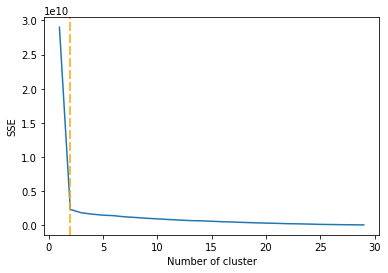

In [11]:
df = final_table[final_columns]
df = df.fillna(df.mean())

sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

kn = KneeLocator(list(sse.keys()), list(sse.values()), curve='convex', direction='decreasing')
knee_val = kn.knee
print(knee_val)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.axvline(x=knee_val, color = 'orange', dashes=[6, 2])
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [12]:
# Choose best k aka n_clusters
kmeans = KMeans(n_clusters=4, max_iter=1000).fit(df)

# Tag your dataset with cluster grouping
final_table["clusters"] = kmeans.labels_

# Visualise your results
final_table[['clusters','Country']]

StockCode,clusters,Country
0,3,AUSTRALIA
1,3,AUSTRIA
2,3,BAHRAIN
3,2,BELGIUM
4,3,BRAZIL
5,3,CANADA
6,2,CHANNEL ISLANDS
7,3,CYPRUS
8,3,CZECH REPUBLIC
9,3,DENMARK


# Iterative KMeans Clustering
However, I wish to believe the problem with the missing data is that the products might not be offered to the countries in the first place. If that is the case, it is unfair to compare no sales for a country that could not have had demand should there be no sellers. <br>
Yet, the dropna() method reduces my dataset drastically, dropping valuable information. <br>
This inspired me to think of a novel method of iteratively doing clustering by a filtered set, tagging the cluster similarity in a correlation matrix, subsequently observing the results.

In [13]:
cty_list = list(country_summary['Country'])
correlation_matrix = pd.DataFrame()
correlation_matrix['Country'] = cty_list
for cty in cty_list:
    correlation_matrix[cty] = 0

In [14]:
correlation_count = correlation_matrix.copy()
correlation_true = correlation_matrix.copy()
correlation_false = correlation_matrix.copy()
correlation_mean = correlation_matrix.copy()

In [15]:
for loop in range(0,100): # if you have more time and computing power, you may loop for more rounds to cover more data
    final_columns = []

    while len(final_columns) <= 10:
        # Randomly Select X Countries
        final_cty_list = random.sample(cty_list, 7)

        # Filter table to Selected Countries
        final_table_15 = final_table[final_table['Country'].isin(final_cty_list)].copy()
        final_table_15 = final_table_15.reset_index(drop=True)
        final_table_15 = final_table_15.dropna(axis='columns')

        # Weight the columns down
        final_columns = [i for i in list(final_table_15) if i not in ['Country', 'clusters']]
    
    #print(final_columns)
    final_table_15['Total'] = final_table_15[final_columns].sum(axis='columns')

    for col in final_columns:
        final_table_15[col] = final_table_15[col]/final_table_15['Total']

    df = final_table_15[final_columns].copy()

    sse = {}
    for k in range(1, 7):
        kmeans = KMeans(n_clusters=k, max_iter=100).fit(df)
        sse[k] = kmeans.inertia_

    try:
        kn = KneeLocator(list(sse.keys()), list(sse.values()), curve='convex', direction='decreasing')
        knee_val = kn.knee
        if knee_val == None:
            knee_val = 7 # force skip art
    except:
        knee_val = 7 # force skip art

    #plt.figure()
    #plt.plot(list(sse.keys()), list(sse.values()))
    #plt.axvline(x=knee_val, color = 'orange', dashes=[6, 2])
    #plt.xlabel("Number of cluster")
    #plt.ylabel("SSE")
    #plt.show()

    # Choose best k aka n_clusters
    kmeans = KMeans(n_clusters=knee_val, max_iter=1000).fit(df)

    # Tag your dataset with cluster grouping
    df["Total"] = final_table_15['Total']
    df["Country"] = final_table_15['Country']
    df["Cluster"] = kmeans.labels_

    for row in range(0,len(df)):
        cty0 = df['Country'][row]
        cluster0 = df['Cluster'][row]
        #print(cty0, cluster0)

        for row in range(0,len(df)):
            cty1 = df['Country'][row]
            cluster1 = df['Cluster'][row]
            #print(cty1, cluster1, cluster0==cluster1)

            if cluster0==cluster1:
                correlation_true.loc[(correlation_true.Country == cty0),cty1] += 1
                correlation_true = correlation_true.fillna(0)
            else:
                correlation_false.loc[(correlation_false.Country == cty0),cty1] += -1
                correlation_false = correlation_false.fillna(0)

            correlation_count.loc[(correlation_count.Country == cty0),cty1] += 1
            correlation_count = correlation_count.fillna(0)

correlation_mean = correlation_true.add(correlation_false)
correlation_mean = correlation_true.set_index('Country').divide(correlation_count.set_index('Country')).reset_index()
correlation_mean = correlation_mean.fillna(0)

C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWarning: No knee/elbow found
C:\ProgramData\Anaconda3\envs\env01\lib\site-packages\ipykernel_launcher.py:192: UserWar

In [16]:
correlation_mean = correlation_true.add(correlation_false)
correlation_mean = correlation_true.set_index('Country').divide(correlation_count.set_index('Country')).reset_index()
correlation_mean = correlation_mean.fillna(0)
correlation_mean

,Country,UNITED KINGDOM,NETHERLANDS,EIRE,GERMANY,FRANCE,AUSTRALIA,SWEDEN,SWITZERLAND,SPAIN,...,UNITED ARAB EMIRATES,MALTA,LITHUANIA,CZECH REPUBLIC,EUROPEAN COMMUNITY,LEBANON,BRAZIL,RSA,BAHRAIN,SAUDI ARABIA
0,UNITED KINGDOM,1.000000,0.333333,0.846154,0.583333,0.200000,0.117647,0.333333,0.285714,0.315789,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NETHERLANDS,0.333333,1.000000,0.461538,0.615385,0.769231,0.600000,0.250000,0.416667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EIRE,0.846154,0.461538,1.000000,0.600000,0.461538,0.000000,1.000000,0.444444,0.250000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GERMANY,0.583333,0.615385,0.600000,1.000000,0.583333,0.500000,0.142857,0.909091,0.076923,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FRANCE,0.200000,0.769231,0.461538,0.583333,1.000000,0.571429,0.166667,0.636364,0.125000,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,AUSTRALIA,0.117647,0.600000,0.000000,0.500000,0.571429,1.000000,0.200000,0.230769,0.071429,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,SWEDEN,0.333333,0.250000,1.000000,0.142857,0.166667,0.200000,1.000000,0.200000,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,SWITZERLAND,0.285714,0.416667,0.444444,0.909091,0.636364,0.230769,0.200000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,SPAIN,0.315789,0.000000,0.250000,0.076923,0.125000,0.071429,0.285714,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,JAPAN,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


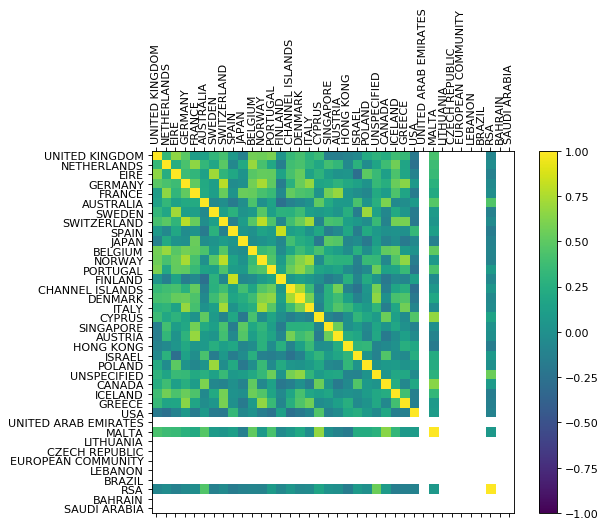

In [17]:
import matplotlib.pyplot as plt
import numpy as np

correlations = correlation_mean.corr()

# plot correlation matrix
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(cty_list),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(cty_list, rotation='vertical')
ax.set_yticklabels(cty_list)
plt.show()
fig.savefig(os.path.join('results',('Correlation Matrix ' + str(category)+'.png')))

This final correlation matrix plot best captures almost all data points and successfully negates the problem of missing data hampering clustering work. <br>
I believe this idea of grouping subsets and observing the clusters could be studied further with other clustering techniques, and also via a more mathematical/ formulaic approach to improve the robustness of this methodology.

Note that one major loophole is that countries like Saudi Arabia with 10 unique rows of data only is unlikely to appear in the final_table_15 dataframe with other common SKUs.